# Test SST Indices Calculations

In [28]:
import sys
sys.path.append(sys.path[0]+'/../..')


import helpers.fileHandler as fh
import utils.sstIndex as sst
import utils._indexDefinitions as _index

In [29]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy
import cftime
import xarray

%matplotlib inline

In [30]:
#get a list of index names to iterate, and then add indian ocean dipole, as a special case
indexNames = list(_index.sstIndex.keys())
indexNames.append('dmi')

In [31]:
def plotter():

    for keys in indexNames:

        try:
            #test if this is an index in cvdp
            cvdp[keys]

        except:
            print (keys, " not defined in Cvdp")        

        else:
            #plot

            #load into memory so it doesn't get loaded twice if we want to use it later
            indexDs[keys].load()

            # set-up plot
            fig = plt.figure(figsize=(15,6))
            ax = fig.add_subplot(1, 1, 1)

            #plot the cvdp
            cvdp[keys].plot(color='green' ,label='from CVDP')

            #plot the calculated one
            indexDs[keys+'NoDetrend'].plot(color='orange',label='calculated')

            #set the horizontal axis to something nice
            plt.xlim(cftime.DatetimeNoLeap(1750,1,1), cftime.DatetimeNoLeap(2000,1,1))

            #add axis names and title
            plt.title(keys.capitalize())
            plt.ylabel("index", fontsize=16)  
            plt.xlabel("Year", fontsize=16)

            #make it neat
            plt.tick_params(which = 'minor', labelsize=13, length=4)
            plt.tick_params(which = 'major', labelsize=13, length=7)
            ax.grid(which='major', alpha=0.3, linestyle='dashed')

            #show the legend based on the 'labels' set above
            plt.legend()

            #make it so
            plt.show()

            print(keys, " standard deviation of difference: ", (indexDs[keys+'NoDetrend']-cvdp[keys]).std().values)


First load up the cvdp and figure out the details of the index we want to calculate

In [32]:
cvdp = fh.loadModelData('CESM-LME', 'cvdp_data', '005')

cvdp = cvdp.rename_vars({'indian_ocean_dipole':'dmi'})


E:/CMIP5-PMIP3/CESM-LME/cesm1.lm.cvdp_data/
Files imported: 
 ['E:/CMIP5-PMIP3/CESM-LME/cesm1.lm.cvdp_data/b.e11.BLMTRC5CN.f19_g16.005.cvdp_data.850-2005.nc']


Do a sanity check of what the areas are to calculate the indeces

In [33]:
for keys in indexNames:
    try:
        print(keys, ": ", cvdp[keys].comment_cvdp)
    except:
        print (keys, " not defined in Cvdp")



nino34 :  area average domain (-5:5N, 190:240E)
nino4 :  area average domain (-5:5N, 160:210E)
westIO  not defined in Cvdp
eastIO  not defined in Cvdp
backgroundSst  not defined in Cvdp
dmi :  area average domain (-10:10N, 50:70E) - (-10:0N, 90:110E)


In [34]:
cvdp.time

<xarray.DataArray 'time' (time: 13872)>
array([cftime.DatetimeNoLeap(850, 1, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(850, 2, 28, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(850, 3, 31, 0, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2005, 10, 31, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2005, 11, 30, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2005, 12, 31, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 0850-01-31 00:00:00 ... 2005-12-31 00:00:00

Next load the model outputs, but drop all the variables we don't care about

In [35]:
ds = fh.loadModelData('CESM-LME', 'SST', '005',drop_variables=('ANGLE','ANGLET', 'DXT', 'DXU', 'DYT', 'DYU', 'HT', 'HTE', 'HTN',
              'HU', 'HUS', 'HUW', 'KMT', 'KMU', 'REGION_MASK', 'T0_Kelvin',
              'UAREA', 'cp_air', 'cp_sw', 'days_in_norm_year', 'dz', 'dzw', 'fwflux_factor', 
              'grav', 'heat_to_PW', 'hflux_factor', 'latent_heat_fusion', 'latent_heat_vapor',
              'mass_to_Sv', 'moc_components', 'momentum_factor','nsurface_t', 'nsurface_u', 
              'ocn_ref_salinity', 'omega', 'ppt_to_salt', 'radius', 'rho_air', 'rho_fw', 'rho_sw',
              'salinity_factor', 'salt_to_Svppt', 'salt_to_mmday', 'salt_to_ppt', 'sea_ice_salinity',
              'sflux_factor', 'sound', 'stefan_boltzmann', 'transport_components', 'transport_regions',
              'vonkar','z_t_150m', 'z_w', 'z_w_bot', 'z_w_top', 'moc_z', 'lat_aux_grid', 'time_bound','z_t', 'ULAT', 'ULONG') )

E:/CMIP5-PMIP3/CESM-LME/mon/SST/
Files imported: 
 ['E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.085001-089912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.090001-099912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.100001-109912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.110001-119912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.120001-129912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.130001-139912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.140001-149912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.150001-159912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.160001-169912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.170001-179912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN

In [36]:
ds.SST

<xarray.DataArray 'SST' (time: 13872, z_t: 1, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(13872, 1, 384, 320), dtype=float32, chunksize=(1872, 1, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time     (time) object 0850-01-31 00:00:00 ... 2005-12-31 00:00:00
Dimensions without coordinates: z_t, nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

# Calculate the indeces from the model outputs

Ds looks like CESM


C:\Anaconda3\lib\site-packages\xarray\core\indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Anaconda3\lib\site-packages\xarray\core\indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 97 times more chunks
  return self.array[key]
C:\Anaconda3\lib\site-packages\xarray\core\indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set t

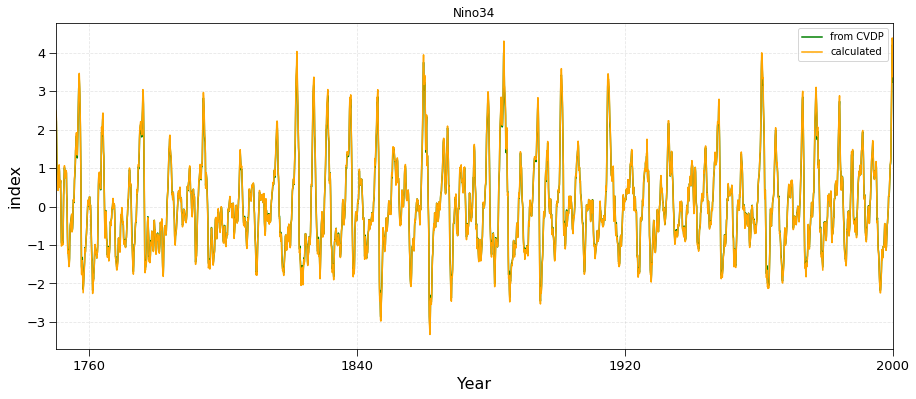

nino34  standard deviation of difference:  0.054329349919590826


C:\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


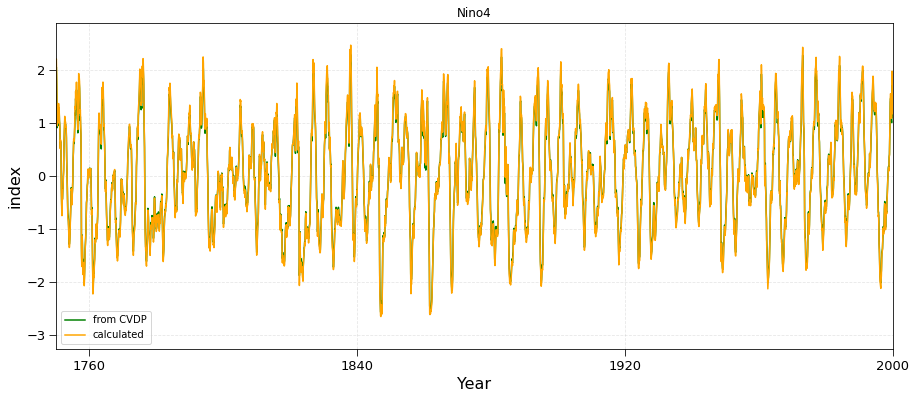

nino4  standard deviation of difference:  0.06313411646447016
westIO  not defined in Cvdp
eastIO  not defined in Cvdp
backgroundSst  not defined in Cvdp


C:\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


KeyError: 'dmiNoDetrend'

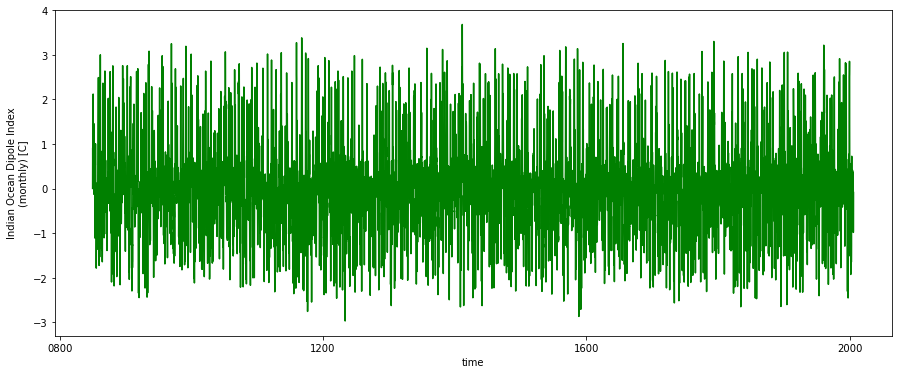

In [37]:
indexDs = sst.calculateIndex(ds, 850, 2005) #based on 850 to 2005 climatology per CVDP

plotter()

Do a comparison plot. Between calculated indexes and cvdp

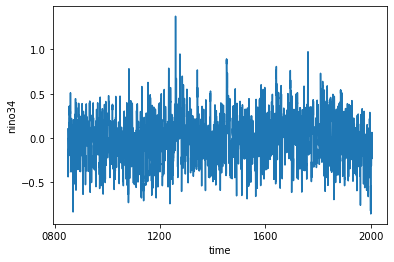

In [11]:
#Compare calulcate nino to the cvdp version
(indexDs.nino34-cvdp.nino34).plot()

In [12]:
#save the answer, in case we want it later
indexDs.to_netcdf("../results/monthlySstIndicesCalculated.nc")

C:\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


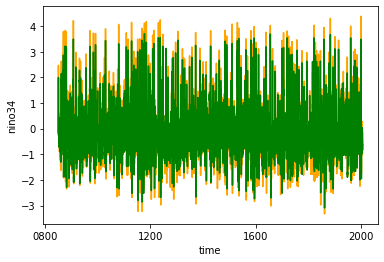

In [13]:
indexDs['nino34NoDetrend'].plot(color='orange',label='calculated')
indexDs['nino34'].plot(color='green',label='detrended')

# Same again, but use the climatology from the control run

In [14]:
experimentDs = fh.loadModelData('CESM-LME', 'SST', '005',drop_variables=('ANGLE','ANGLET', 'DXT', 'DXU', 'DYT', 'DYU', 'HT', 'HTE', 'HTN',
              'HU', 'HUS', 'HUW', 'KMT', 'KMU', 'REGION_MASK', 'T0_Kelvin',
              'UAREA', 'cp_air', 'cp_sw', 'days_in_norm_year', 'dz', 'dzw', 'fwflux_factor', 
              'grav', 'heat_to_PW', 'hflux_factor', 'latent_heat_fusion', 'latent_heat_vapor',
              'mass_to_Sv', 'moc_components', 'momentum_factor','nsurface_t', 'nsurface_u', 
              'ocn_ref_salinity', 'omega', 'ppt_to_salt', 'radius', 'rho_air', 'rho_fw', 'rho_sw',
              'salinity_factor', 'salt_to_Svppt', 'salt_to_mmday', 'salt_to_ppt', 'sea_ice_salinity',
              'sflux_factor', 'sound', 'stefan_boltzmann', 'transport_components', 'transport_regions',
              'vonkar','z_t_150m', 'z_w', 'z_w_bot', 'z_w_top', 'moc_z', 'lat_aux_grid', 'time_bound','z_t', 'ULAT', 'ULONG') )

E:/CMIP5-PMIP3/CESM-LME/mon/SST/
Files imported: 
 ['E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.085001-089912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.090001-099912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.100001-109912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.110001-119912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.120001-129912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.130001-139912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.140001-149912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.150001-159912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.160001-169912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN.f19_g16.005.pop.h.SST.170001-179912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.BLMTRC5CN

Load the ds to use for climatology

In [15]:
controlDs = fh.loadModelData('CESM-LME', 'SST', '0850cntl.001',drop_variables=('ANGLE','ANGLET', 'DXT', 'DXU', 'DYT', 'DYU', 'HT', 'HTE', 'HTN',
              'HU', 'HUS', 'HUW', 'KMT', 'KMU', 'REGION_MASK', 'T0_Kelvin',
              'UAREA', 'cp_air', 'cp_sw', 'days_in_norm_year', 'dz', 'dzw', 'fwflux_factor', 
              'grav', 'heat_to_PW', 'hflux_factor', 'latent_heat_fusion', 'latent_heat_vapor',
              'mass_to_Sv', 'moc_components', 'momentum_factor','nsurface_t', 'nsurface_u', 
              'ocn_ref_salinity', 'omega', 'ppt_to_salt', 'radius', 'rho_air', 'rho_fw', 'rho_sw',
              'salinity_factor', 'salt_to_Svppt', 'salt_to_mmday', 'salt_to_ppt', 'sea_ice_salinity',
              'sflux_factor', 'sound', 'stefan_boltzmann', 'transport_components', 'transport_regions',
              'vonkar','z_t_150m', 'z_w', 'z_w_bot', 'z_w_top', 'moc_z', 'lat_aux_grid', 'time_bound','z_t', 'ULAT', 'ULONG') )

E:/CMIP5-PMIP3/CESM-LME/mon/SST/
Files imported: 
 ['E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.B1850C5CN.f19_g16.0850cntl.001.pop.h.SST.085001-089912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.B1850C5CN.f19_g16.0850cntl.001.pop.h.SST.090001-099912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.B1850C5CN.f19_g16.0850cntl.001.pop.h.SST.100001-109912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.B1850C5CN.f19_g16.0850cntl.001.pop.h.SST.110001-119912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.B1850C5CN.f19_g16.0850cntl.001.pop.h.SST.120001-129912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.B1850C5CN.f19_g16.0850cntl.001.pop.h.SST.130001-139912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.B1850C5CN.f19_g16.0850cntl.001.pop.h.SST.140001-149912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.B1850C5CN.f19_g16.0850cntl.001.pop.h.SST.150001-159912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.B1850C5CN.f19_g16.0850cntl.001.pop.h.SST.160001-169912.nc', 'E:/CMIP5-PMIP3/CESM-LME/mon/SST/b.e11.B1850C5CN.f19_g16.

Calculate the indeces from the model outputs

In [16]:
climatDs = sst.calculateClimatology(controlDs, 850, 2005) #based on 850 to 2005 climatology per CVDP


C:\Anaconda3\lib\site-packages\xarray\core\indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Anaconda3\lib\site-packages\xarray\core\indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Anaconda3

In [17]:
indexDs = sst.calculateIndex(experimentDs, climatDs) 

C:\Anaconda3\lib\site-packages\xarray\core\indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


Ds looks like CESM


C:\Anaconda3\lib\site-packages\xarray\core\indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 97 times more chunks
  return self.array[key]
C:\Anaconda3\lib\site-packages\xarray\core\indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Anaconda3\lib\site-packages\xarray\core\indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 97 times more chunks
  return self.array[key]
C:\Anaconda3\lib\site-packages\xarray\core\indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 97 times more chunks
  r

C:\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


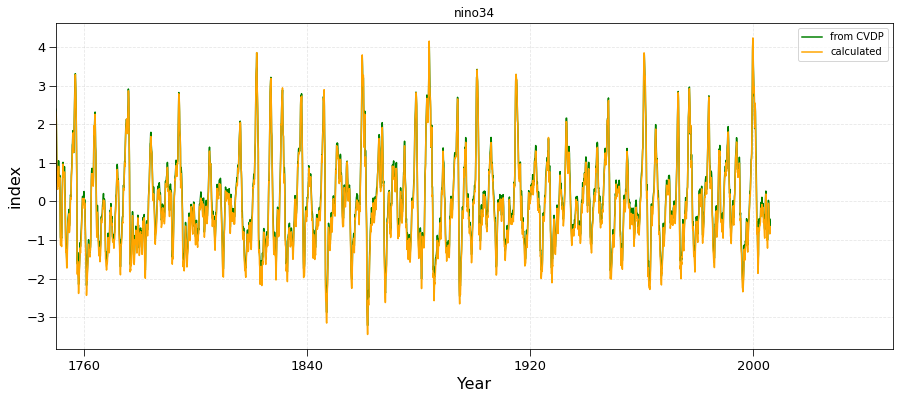

nino34  standard deviation of difference:  0.06603293944339249


C:\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


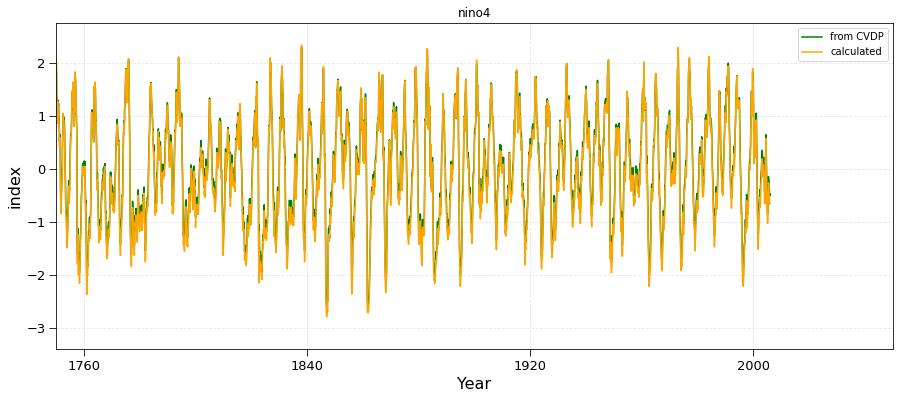

nino4  standard deviation of difference:  0.06666764549664086
westIO  not defined in Cvdp
eastIO  not defined in Cvdp
backgroundSst  not defined in Cvdp


C:\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


KeyError: 'dmiNoDetrend'

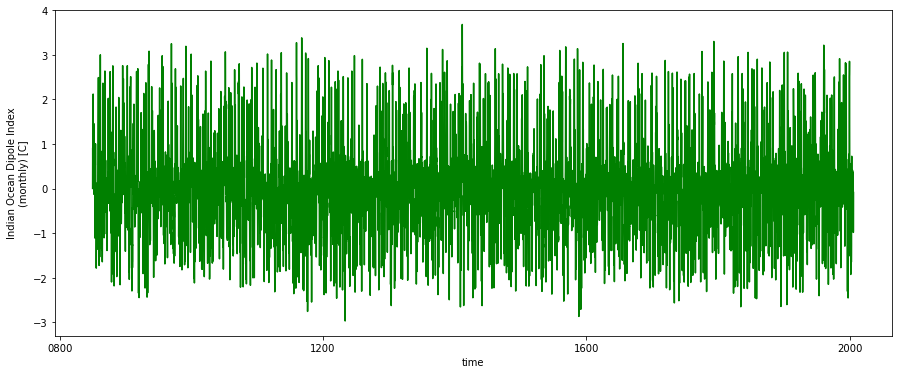

In [18]:
plotter()

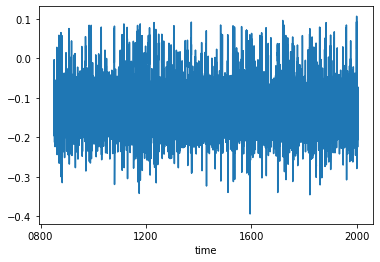

In [19]:
#Compare calulcate nino to the cvdp version
(indexDs.nino34NoDetrend-cvdp.nino34).plot()

In [20]:
#save the answer, in case we want it later
indexDs.to_netcdf("../results/monthlySstIndicesCalculatedDiffClimatology.nc")

C:\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [21]:
indexDsStandClimat = xarray.open_dataset('../results/monthlySstIndicesCalculated.nc')

(-91250.0, 18250.0)

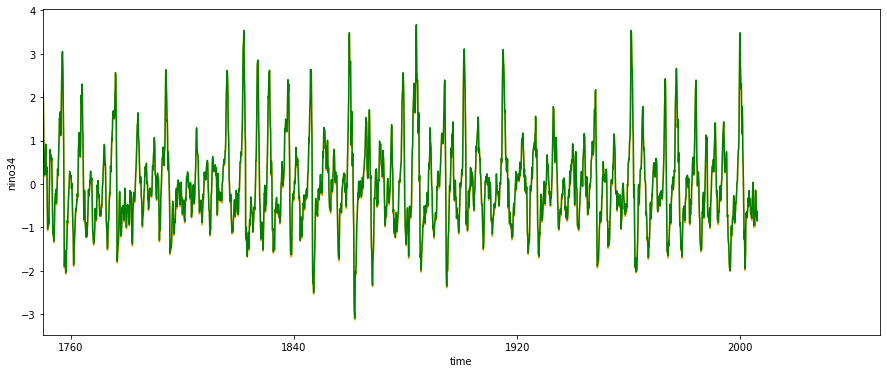

In [22]:
# set-up plot
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 1, 1)
#plot the calculated one
indexDs['nino34'].plot(color='orange',label='calculated')
indexDsStandClimat['nino34'].plot(color='green',label='calculated')
   #set the horizontal axis to something nice
plt.xlim(cftime.DatetimeNoLeap(1750,1,1), cftime.DatetimeNoLeap(2050,1,1))


# And again with CMIP6

In [24]:
cvdp = fh.loadModelData('ACCESS-CM2', 'cvdp_data', 'ssp370')

cvdp = cvdp.rename_vars({'indian_ocean_dipole':'dmi'})


E:/CMIP5-PMIP3/cmip6.ssp370.cvdp_data/


OSError: Requested files E:/CMIP5-PMIP3/cmip6.ssp370.cvdp_data/ not found. Is the harddrive plugged in and does this test case exist?

In [ ]:
cvdp.climatology

In [ ]:
cvdp

In [ ]:
tsDs = fh.loadModelData('IPSL-CM5A-LR', 'ts', 'past1000')
fxDs = fh.loadModelData('IPSL-CM5A-LR', 'areacella_fx', 'historical') #There is no file produced for past1000, but the resolution is the same?

In [ ]:
ds=xarray.merge([tsDs.ts, fxDs.areacella])

ds=ds.assign_attrs({'project_id':'CMIP5'})


Using model as climatology

In [ ]:
import regex as re

cfTimeRe=re.compile('cftime._cftime.Datetime360Day')

if cfTimeRe.search(str(type(tsDs.time.values[0]))) :
    print('treu')

In [ ]:
climatDs=sst.calculateClimatology(ds, 850, 1849)

indexDs = sst.calculateIndex(ds, climatDs) 

In [ ]:
indexDs

In [ ]:
indexDs.nino34.plot()

In [ ]:
plotter()

Using control run as climatology

In [ ]:
tsDs = fh.loadModelData('IPSL-CM5A-LR', 'ts', 'past1000')
fxDs = fh.loadModelData('IPSL-CM5A-LR', 'areacella_fx', 'historical') #There is no file produced for past1000, but the resolution is the same?

In [ ]:
ds=xarray.merge([tsDs.ts, fxDs.areacella])
ds=ds.assign_attrs({'project_id':'CMIP5'})


In [ ]:
tsControlDs = fh.loadModelData('IPSL-CM5A-LR', 'ts', 'piControl')


In [ ]:
controlDs=xarray.merge([tsControlDs.ts, fxDs.areacella])
controlDs=controlDs.assign_attrs({'project_id':'CMIP5'})


In [ ]:
controlDs

In [ ]:
climatDs=sst.calculateClimatology(controlDs)

Using model as climatology

In [ ]:
indexDs = sst.calculateIndex(ds, climatDs) 

In [ ]:
indexDs

In [ ]:
plotter()